# Course Motivation

Engineers solve problems. You as a chemical engineer are likely excited to collaborate with others to use chemistry and physics together with other engineering principles to solve problems our society faces.

## Current Worldwide Problems in Engineering
Chemical Engineers are poised to help in each of these areas:
* Energy 
    - Worldwide `energy demands are growing`
    - We need to use fossil fuels more efficiently and capture more of the biproducts
    - [Energy.gov](https://www.energy.gov/)
        - Fry, Memmott, Baxter, Rappleye, Wheeler, and Lignell
* Chemical Production
    - We can continue to `improve chemical production` processes
    - [Chemical and Engineering News](https://cen.acs.org/)
        - Argyle, Hedengren, Knotts, Nickerson, Seo, Tree, Wilding
* Health 
    - We need to `improve` health care delivery and care
    - [World Health Organization](https: //www.who.int/)
        - Bundy, Pitt, and Lewis
* Water 
    - We need to improve water treatment,  distribution, and conservation.
    - [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/drinking-water)
* Transportation - How do we better move people and goods around the world?
* Environment - How do we efficiently continue improving our environment?
    - Plastics production and waste handling and reuse needs improvement.
    - [Environmental Protection Agency](https://www.epa.gov/)
* Security - How do we continue to adapt and peacefully protect people from threats?
* Exploration, Food, and more...

You are the engineers that will work to improve societies' and individuals' quality of life around the world.

## What tools will you use to solve these problems?
* You'll stand on the backs of giants and be familiar with their successes.
* You'll **collaborate with others**.
* You'll utilize both:
    - **Computational tools** - to solve problems with computers
    - **Experimental methods** - to gain further insights.
    - Coupling both theoretical and experimental methods is a more efficient way to reach the best solution than either one alone.


This course is focused primarily on helping you become more familiar with computation tools in an applied engineering context.

## Intro Demonstration
`Flames` are critical to many processes that benefit us: cooking, heating, transportation, electricity, etc. The combustion products from burning fuels can present problems. However, we have been reducing those negative effects for decades. Below is a plot by the EPA showing that trend of improvement ([also here](https://www.epa.gov/air-trends/air-quality-national-summary)):

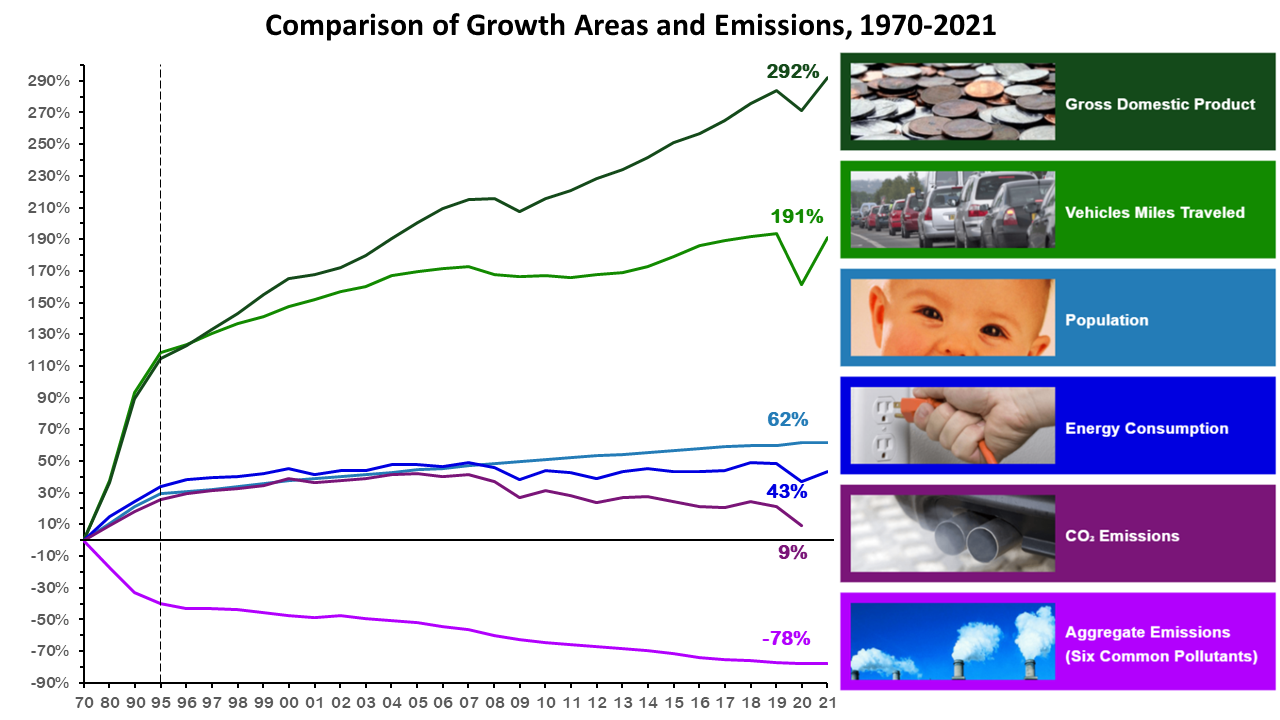

### Flames are Ubiquitous
In this example we'll measure the temperature of a butane flame with a thermocouple and a low-cost data acquisition unit (ESP32) with an amplifier(MAX6675). We'll also predict the temperature of the flame using several models in python.

The below theoretical example problem calculates  the adiabatic (no heat losses) flame temperature of butane (C4H10) and air mixture. The first method is completed with a model of the enthalpy of formation of the reactants and products and the heat of combustion. The second method uses the Cantera package to calculate the adiabatic flame temperature. 

\begin{equation}
C_4H_{10} + 6.5\cdot O_2 + x\cdot N_2 => 4\cdot CO_2 + 5\cdot H_2O + x\cdot N_2
\end{equation}

$x$ number of moles of nitrogen can be found from the nitrogen balance where assuming that the amount of air in the atmosphere is 79% nitrogen and 21% oxygen. Thus x is simply the number of moles of oxygen divided by 0.21 multiplied by 0.79 (6.5*0.79/0.21 = 24.4).

### First manually calculate the adiabatic flame temperature
For butane combustion the below code calculates the adiabatic flame temperature using the enthalpy of formation of the reactants and products and the heat of combustion as well as the heat capacities of the products

In [1]:
# Adiabatic flame temperature of butane-air mixture from heats of formation

# First import the needed packages
import numpy as np 
import matplotlib.pyplot as plt
from scipy import integrate
import param

# Define the reaction:
# C4H10 + 6.5O2 + 24.4N2 => 4CO2 + 5H2O + 24.4N2

#define a class for the reactants and products
class species(param.Parameterized):
    H_rxn = param.Number(-1,bounds=(-1e10,0),doc='Heat of Reaction in kJ/mol')
    H_f = param.Number(-1,bounds=(-1e10,0),doc='Heat of Formation in kJ/mol')
    C_pgl = param.List([1,1,1,1,1],doc='Heat capacity coefficients in J/kmol/K')
    M_w = param.Number(1,bounds=(0,10000),doc='Molecular weight in g/mol')
    coeff = param.Number(1,bounds=(-100,100),doc='Stoichiometric coefficient')

    #define a function to calculate the ideal gas heat capacity
    def Cp(self,T):
        A = self.C_pgl[0]; B = self.C_pgl[1]; C = self.C_pgl[2]; D = self.C_pgl[3]; E = self.C_pgl[4]; 
        return A + B*((C/T)/np.sinh(C/T))**2 + D*((E/T)/np.cosh(E/T))**2 
    
    #define a function to calculate the enthalpy based on the ideal gas heat capacity
    def enthalpy(self,T,TO): #units of kJ/mol
        return self.coeff*(integrate.quad(self.Cp,TO,T)[0]/1e6)

#define reactants and products (estimated) for butane combustion
C4H10 = species(H_rxn=-2657.32,H_f=-125,C_pgl=[80152,162410,841,105747,2476],M_w=58.12,coeff=-1)
O2 = species(H_rxn=0,H_f=0,C_pgl=[29100,10040,2526,9356,1153],M_w=32.0,coeff=-6.5)
CO2 = species(H_rxn=0,H_f=-394,C_pgl=[29370,34540,1428,26400,588],M_w=44.01,coeff=4)
H2O = species(H_rxn=0,H_f=-242,C_pgl=[33363,26790,2610,8896,1169],M_w=18.02,coeff=5)
N2 = species(H_rxn=0,H_f=0,C_pgl=[29105,8615,1701,103,910],M_w=28.01,coeff=-24.4)


ModuleNotFoundError: No module named 'numpy'

\begin{equation}
\sum_{out}{n_iH_i(T_{ad})}  + n_f\Delta H_{c} - \sum{n_i H_i(T_{in})} = 0 \tag{1}
\end{equation}

In [2]:
#define initial conditions
T0 = 298.0 #K

#define a function for the enthalpy of the reactants
def H_react(T):
    formation = C4H10.coeff*C4H10.H_f + O2.coeff*O2.H_f + O2.coeff*N2.H_f
    return C4H10.enthalpy(T,T0) + O2.enthalpy(T,T0) + N2.enthalpy(T,T0) + formation

#also define a function for the enthalpy of the products
def H_prod(T):
    return CO2.enthalpy(T,T0) + H2O.enthalpy(T,T0) - N2.enthalpy(T,T0)

In [3]:
# Use fsolve to find the addiabatic temperature from Equation 1
# first import the fsolve function
from scipy.optimize import fsolve
# next react the reactants to the products at T0 then heat the products to the adiabatic temperature
T_ad = fsolve(lambda T: H_react(T0) + C4H10.coeff*C4H10.H_rxn - H_prod(T),T0)[0]
print(f'The adiabatic flame temperature is {T_ad-273:.2f} C')

The adiabatic flame temperature is 2217.02 C


### Second calculate the adiabatic flame temperature using Cantera

In [92]:
import cantera as ct
gas1 = ct.Solution('sdmech.yaml')
gas1.TP = T0, ct.one_atm
gas1.set_equivalence_ratio(1.0, 'C4H10', 'O2:1, N2:3.76')
gas1.equilibrate('HP')
print(f'The equilibrium flame temperature is {gas1.T-273:.2f} C')
comps = gas1['H2O','CO2','N2','O2'].X
print(f'The eq. gas mole fractions for H2O, CO2, N2, O2 are {comps[0]:.2f},{comps[1]:.2f},{comps[2]:.2f},{comps[3]:.2f}, respectively')
gas1()

The equilibrium flame temperature is 2001.39 C
The eq. gas mole fractions for H2O, CO2, N2, O2 are 0.14,0.11,0.72,0.01, respectively

  gas:

       temperature   2274.4 K
          pressure   1.0132e+05 Pa
           density   0.15093 kg/m^3
  mean mol. weight   28.167 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.3233e+05       -3.7274e+06  J
   internal energy       -8.0368e+05       -2.2638e+07  J
           entropy            9672.3        2.7244e+05  J/K
    Gibbs function       -2.2131e+07       -6.2337e+08  J
 heat capacity c_p            1471.7             41454  J/K
 heat capacity c_v            1176.5             33140  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                N2           0.72011           0.72406           -27.696
           

### Cantera can also estimate the species and temperature  in a 1-D flame

In [106]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
Tin = 300.0  # unburned gas temperature [K]
reactants = 'C4H10:1, O2:6.5, N2:24.4'  # premixed gas composition
width = 0.0005  # m
loglevel = 1  # amount of diagnostic output (0 to 8)

# Solution object used to compute mixture properties, set to the state of the
# upstream fuel-air mixture
gas = ct.Solution('sdmech.yaml')
gas.TPX = Tin, p, reactants

# Set up flame object
f = ct.FreeFlame(gas, width=width)
f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
#f.show_solution()

# Solve with mixture-averaged transport model
f.transport_model = 'Mix'
f.solve(loglevel=loglevel, auto=True)
#f.show_solution()



************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.375e-05      6.359
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.949e-09      5.963
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.722e-13      5.963
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps   
 
*******************************************************************************
CanteraError thrown by OneDim::timeStep:
Time integration failed.
*******************************************************************************
 

******** Initial solve failed; Retrying with energy equation disabled ********

..............................................................................
Attempt Newton solution of steady-state prob

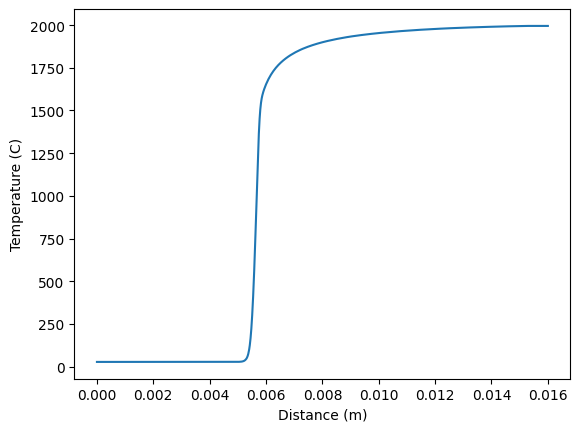

In [107]:
plt.plot(f.grid, f.T-273, label='T')
plt.xlabel('Distance (m)')
plt.ylabel('Temperature (C)')
plt.show()



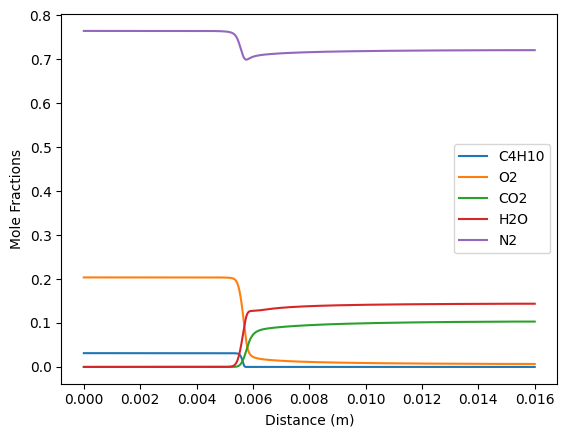

In [111]:

plt.plot(f.grid, f.X[gas.species_index('C4H10')], label='C4H10')
plt.plot(f.grid, f.X[gas.species_index('O2')], label='O2')
plt.plot(f.grid, f.X[gas.species_index('CO2')], label='CO2')
plt.plot(f.grid, f.X[gas.species_index('H2O')], label='H2O')
plt.plot(f.grid, f.X[gas.species_index('N2')], label='N2')
plt.legend(loc='best')
plt.xlabel('Distance (m)')
plt.ylabel('Mole Fractions');
plt.show()

Dr. Lignell discusses combustion processes and numerical methods further in his [Combustion Principles course](https://ignite.byu.edu/che522/index.html). Dr. Baxter has also taught advanced combustion courses.

### Experimental Estimate from a K type Thermocople
An ESP32, MAX6675, and K type thermocouple are used to measure the temperature of the flame. The MAX6675 is a thermocouple amplifier that converts the thermocouple voltage to a digital signal that can be read by the ESP32. The ESP32 is a low-cost microcontroller that can be programmed with the Arduino IDE. The data collected by the ESP32 can be pushed to an andoid phone via classic bluetooth (or to a windows machine via bluetooth).

In [115]:
import pandas as pd #pandas is a data analysis library

A lighter is used to heat a small bead K-type thermocouple. The rating of the K-type thermocouple is up to 1200 C. We'll see how hot we can get the thermocouple.